In [1]:
from data import*
from regression import*

Using TensorFlow backend.


# DATA

In [21]:
# Load Data
# -----------------------------------------------------
def get_data(dataset_name, features='synth_vind'):
    dataset_df_list = load_dataset(dataset_name, as_dict=False)
    X, Y = list(), list()
    for data in dataset_df_list:            
        
        vind = data.filter(regex=features).to_numpy()
        # norm = np.array([list(yn) for yn in data.filter(regex='norm').to_numpy()])[:,0,:]
        # alpha = np.arccos(norm[:,2])*180/pi
        # x = np.concatenate([vind, norm], axis=1)
        x = vind

        y = np.nanmean(np.array([list(yn) for yn in data.filter(regex='center_1').to_numpy()]), axis=1)
        y = np.linalg.norm( y, axis=1)        
        # y = np.linalg.norm( y[:,:2], axis=1)        
        # y = y[:,2]
        # y = alpha

        X.append(x)
        Y.append(y)
    return DATA(X, Y)
# -----------------------------------------------------
train_data_raw, validation_data_raw = get_data( 'synth_2coils_parallel', features='synth_vind').split(ratio=.95) 
test_data_synth_raw = get_data('arduino_parallel', features='synth_vind')
test_data_meas_raw = get_data('arduino_parallel', features='meas_vind')

print(np.shape(train_data_raw.X))
print(np.shape(test_data_meas_raw.X), np.shape(test_data_meas_raw.X[0]))

(1900, 242, 2)
(20,) (289, 2)


In [22]:
# Process Data
def data_processing(data): 
    return data.mtx('min')

train_data = data_processing(train_data_raw)
validation_data = data_processing(validation_data_raw)
test_data_synth = data_processing(test_data_synth_raw)
test_data_meas = data_processing(test_data_meas_raw)

print(np.shape(train_data.X), np.shape(train_data.Y))
print(np.shape(validation_data.X), np.shape(validation_data.Y))
print(np.shape(test_data_synth.X[0]), np.shape(test_data_synth.Y[0]))

(1900, 242, 2) (1900, 242)
(100, 242, 2) (100, 242)
(232, 2) (232,)


# CNN

In [13]:
class CNN(object):
        ######################################################################################################    
    def __init__(self, input_shape, strides, **params ):
        np.random.seed(7)        
        self.input_shape = input_shape
        self.strides = strides
        self.build_model(**params)
    ######################################################################################################
    def build_model(self, activation='softmax', optimizer='adam', loss='mean_squared_error', dropout=0): 
        self.model = Sequential()
        self.model.add(Conv1D( filters=200, kernel_size=20, strides=self.strides, activation=activation, padding='same', input_shape=self.input_shape))
        self.model.add(Conv1D( filters=100, kernel_size=20, strides=self.strides, activation=activation, padding='same'))
        self.model.add(Conv1D( filters=50, kernel_size=10, strides=self.strides, activation=activation, padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Flatten())
        self.model.add(Dense(500, activation=activation))
        # self.model.add(Dropout(dropout))
        self.model.add(Dense(400, activation=activation))
        self.model.add(Dense(self.input_shape[0]))                     

        self.model.compile(loss=loss, optimizer=optimizer)  
        print(self.model.summary())        
        return 
    ######################################################################################################
    def train(self, train_data, **params): 
        history = self.model.fit( train_data.X, train_data.Y, **params) 
        return history
    ######################################################################################################    
    def predict(self, X):
        if np.ndim(X)<3: X = np.array([X])
        if np.shape(X)[1] < self.input_shape[0]:
            pad_size = self.input_shape[0] - np.shape(X)[1]
            npad = [(0, 0)] * X.ndim
            npad[1] = (0, pad_size)
            X = np.pad(X, pad_width=npad, mode='constant', constant_values=0)
        return self.model.predict(X[:, :self.input_shape[0]]) 

In [28]:
regressor = CNN(
    input_shape = np.shape(train_data.X)[1:],
    strides = 1,
    activation = 'elu',
    optimizer = tf.keras.optimizers.Adam( learning_rate=0.0001), 
    loss = 'mean_squared_error', 
    dropout = 0
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 242, 200)          8200      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 242, 100)          400100    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 242, 50)           50050     
_________________________________________________________________
batch_normalization_4 (Batch (None, 242, 50)           200       
_________________________________________________________________
flatten_4 (Flatten)          (None, 12100)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               6050500   
_________________________________________________________________
dense_10 (Dense)             (None, 400)              

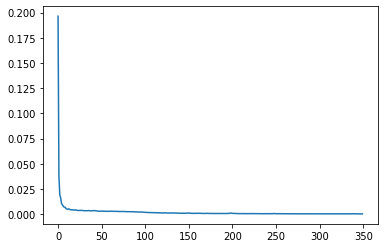

In [29]:
history = regressor.train(train_data, epochs=350, verbose=0)
plt.plot(history.history['loss'])

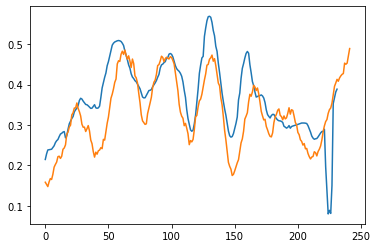

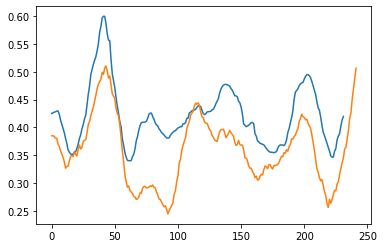

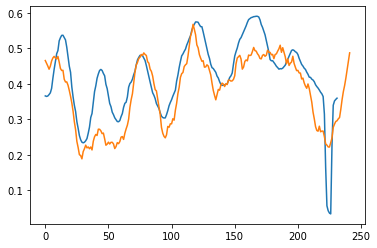

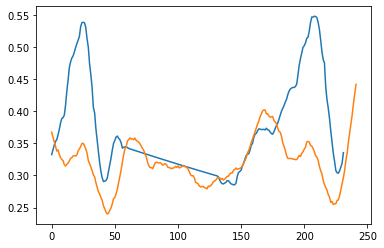

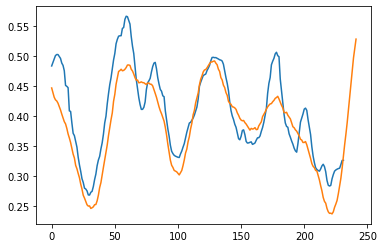

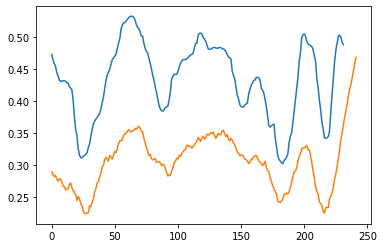

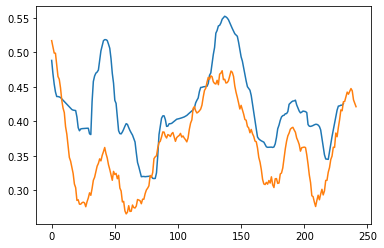

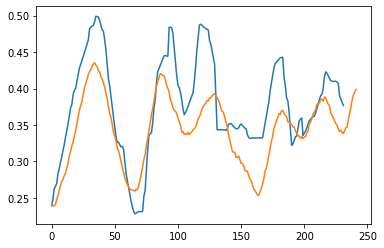

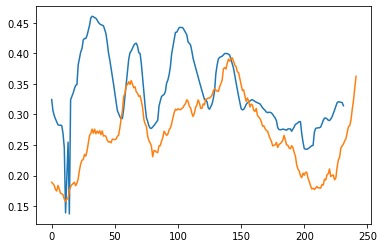

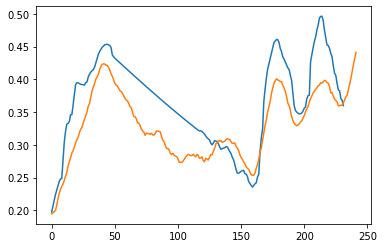

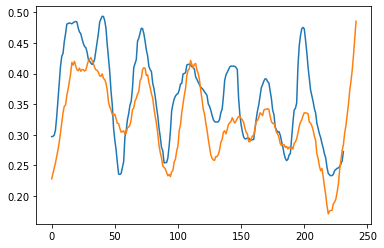

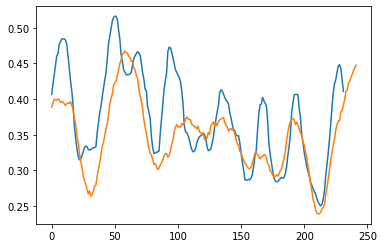

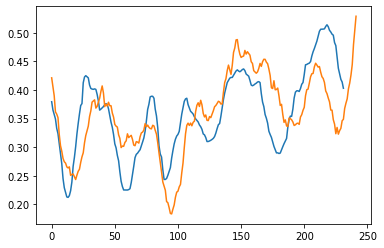

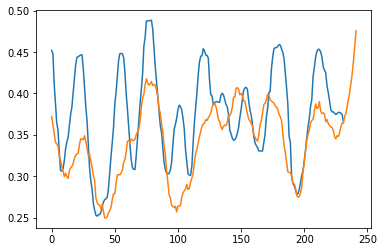

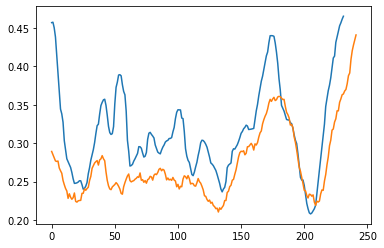

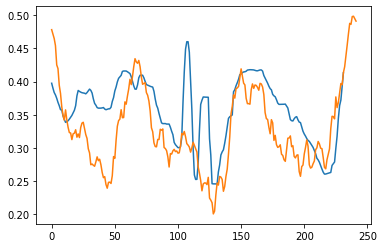

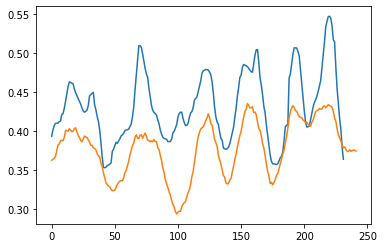

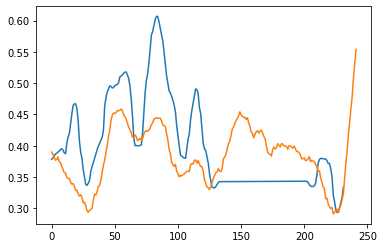

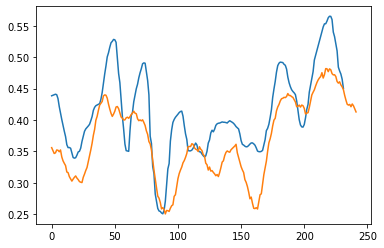

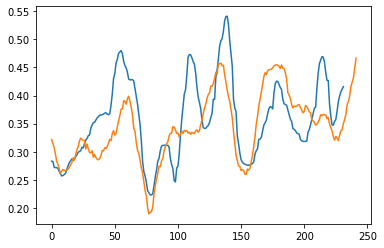

In [32]:
# data = validation_data
data = test_data_meas
# data = test_data_synth

predictions = regressor.predict(data.X)

for (y_true, y_pred) in zip(data.Y, predictions):
    y_pred = signal.savgol_filter( y_pred, window_length=5, polyorder=1, axis=0)       
    plt.plot(y_true, label='Target')
    plt.plot(y_pred, label='Prediction')
    plt.show()
    

# TCN

In [6]:
class TCN(object):
        ######################################################################################################    
    def __init__(self, input_shape, strides, **params ):
        np.random.seed(7)        
        self.input_shape = input_shape
        self.strides = strides
        self.build_model(**params)
        return
    ######################################################################################################
    def build_model(self, Nlayers=2, nb_filters=5, Nfeatures=2, activation=None, optimizer='adam', loss='mse' ):  
        i = tf.keras.Input(batch_shape=(None, self.win_size, Nfeatures)) 
        if Nlayers>1:
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=True)(i)
            for n in range(Nlayers-2): tcn.TCN(nb_filters=nb_filters, return_sequences=True)(o)    
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=False)(o)
        else:
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=False)(i)     
            
        o = tf.keras.layers.Dense(1, activation=activation)(o)
        self.model = tf.keras.Model(inputs=[i], outputs=[o])
        
        self.model.compile(loss='mse', optimizer='adam')
        
        print(self.model.summary())                
        return 

    ######################################################################################################
    def build_model(self, activation='softmax', optimizer='adam', loss='mean_squared_error', dropout=0): 
        self.model = Sequential()
        self.model.add(Conv1D( filters=200, kernel_size=20, strides=self.strides, activation=activation, padding='same', input_shape=self.input_shape))
        self.model.add(Conv1D( filters=100, kernel_size=20, strides=self.strides, activation=activation, padding='same'))
        self.model.add(Conv1D( filters=50, kernel_size=10, strides=self.strides, activation=activation, padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Flatten())
        self.model.add(Dense(500, activation=activation))
        # self.model.add(Dropout(dropout))
        self.model.add(Dense(400, activation=activation))
        self.model.add(Dense(self.input_shape[0]))                     

        self.model.compile(loss=loss, optimizer=optimizer)  
        print(self.model.summary())        
        return 
    ######################################################################################################
    def train(self, train_data, **params): 
        history = self.model.fit( train_data.X, train_data.Y, **params) 
        return history
    ######################################################################################################    
    def predict(self, X):
        if np.ndim(X)<3: X = np.array([X])
        if np.shape(X)[1] < self.input_shape[0]:
            pad_size = self.input_shape[0] - np.shape(X)[1]
            npad = [(0, 0)] * X.ndim
            npad[1] = (0, pad_size)
            X = np.pad(X, pad_width=npad, mode='constant', constant_values=0)
        return self.model.predict(X[:, :self.input_shape[0]]) 

In [ ]:
regressor = TCN(
    win_size = 20,
    step = 1,
    Nlayers = 1,
    nb_filters=64,
    activation = None, 
    optimizer = 'adam', 
    loss = 'mse',
    Nfeatures = train_data.X.shape[2]  
)

# RNN

In [34]:
# regressor = RNN(
#     win_size = 10,
#     Nunits = 30, 
#     NhiddenLayers = 10,
#     activation = 'relu',
#     optimizer = tf.keras.optimizers.Adam( learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
#     loss = 'mean_squared_error', 
#     dropout = 0,
#     Nfeatures = train_data.X.shape[-1]
# )

In [ ]:
# history = regressor.train(train_data, step=10, epochs=10, verbose=1)
# plt.plot(history.history['loss'])

In [ ]:
# data = validation_data.select(np.arange(10))
# predictions = regressor.predict(data.X)

# for (y_true, y_pred) in zip(data.Y, predictions):
#     # y_pred = signal.savgol_filter( y_pred, window_length=11, polyorder=1, axis=0)       
#     plt.plot(y_true, label='Target')
#     plt.plot(y_pred, label='Prediction')
#     plt.show()

In [ ]:
# eps = 1e-12
# class DATA(object):    
#     # ---------------------------------------------------------------------------------------------------   
#     def __init__(self, database_name, target, features, records_numbers=None):            
#         self.X, self.Y = list(), list()     
#         self.load(database_name, target, features, records_numbers=records_numbers)
#         return
#     # ---------------------------------------------------------------------------------------------------       
#     def load(self, database_name, target, features, records_numbers=None):
#         if records_numbers is None:
#             folder_path = os.path.dirname( get_dataset_file_path(database_name,'') )   
#             file_path_list = list(Path(folder_path).glob('*.pkl'))
#         else:
#             file_path_list = [get_dataset_file_path(database_name, 'record_'+"{0:0=2d}".format(n)) for n in records_numbers]
            
#         for file_path in file_path_list:                 
#             data = pd.read_pickle( file_path )

#             y = data.filter(regex=target, axis=1).values  
#             x = [data.filter(regex=feature, axis=1).values for feature in features]            
            
#             # lists
#             self.X.append( np.concatenate(x, axis=1) )
#             self.Y.append( y.reshape((len(y))) )

#         X = np.array(self.X)
#         Y = np.array(self.Y)
#         return
#     # ---------------------------------------------------------------------------------------------------       
#     def merge(self, new_dataset):
#         merged_dataset = copy.deepcopy(self)
#         merged_dataset.X = np.array([*self.X, *new_dataset.X])
#         merged_dataset.Y = np.array([*self.Y, *new_dataset.Y])
#         return merged_dataset
#     # ---------------------------------------------------------------------------------------------------       
#     def select(self, idx_list):
#         selected_dataset = copy.deepcopy(self)
#         selected_dataset.X = self.X[idx_list]
#         selected_dataset.Y = self.Y[idx_list]
#         return selected_dataset
#     # ---------------------------------------------------------------------------------------------------
#     def split(self, ratio):
#         N = len(self.X)
#         idxs = np.arange(N)
#         random.shuffle(idxs)
        
#         Ntrain = int(N*ratio)
#         data_p1 = self.select(idxs[:Ntrain])
#         data_p2 = self.select(idxs[Ntrain:])
        
#         return data_p1, data_p2
#     # ---------------------------------------------------------------------------------------------------       
#     def mtx( self, Nt_mtx='max' ):  
#         # This function padds or cuts all input data (X) to make them same length and generate matrix data(X_mtx)
#         # it also nomalize data X-mean(X)
#         data_mtx = copy.deepcopy(self)
#         if len(np.shape(data_mtx.X))>1:  return data_mtx    

#         Nt_list = [np.shape(x)[0] for x in self.X]
#         Nt = int( eval('np.' + Nt_mtx)(Nt_list) )
#         Nd, Nf = len(self.X),  np.shape(self.X[0])[1]
        
#         data_mtx.X = np.zeros( (Nd,Nt,Nf) )
#         data_mtx.Y = np.zeros( (Nd,Nt) )
        
#         for idx, x in enumerate(self.X): 
#             nt = np.shape(x)[0]
            
#             if Nt >= nt:
#                 data_mtx.X[idx,:,:] = np.pad( x, ((0,Nt-nt),(0,0)),'constant')
#                 data_mtx.Y[idx,:nt] = self.Y[idx]
                
#             else:
#                 data_mtx.X[idx,:,:] = x[:Nt,:]
#                 data_mtx.Y[idx, :] = self.Y[idx][:Nt]
#         return data_mtx
#     # ---------------------------------------------------------------------------------------------------   
#     def bound(self, min_value=None, max_value=None):
#         # This function limits the amplitude value 
        
#         bounded_data = copy.deepcopy(self)
#         if min_value is not None:
#             for x in bounded_data.X: x[ x<min_value ] = min_value
#         if max_value is not None:                
#             for x in bounded_data.X: x[ x>max_value ] = max_value
        
#         return bounded_data
#     # ---------------------------------------------------------------------------------------------------   
#     def trim(self, keep_ratio=None):
#         trimmed_data = copy.deepcopy(self)
#         trimmed_data.X = list()
        
#         if keep_ratio is None:
#             dt = 20   
#             for x in self.X:     
#                 N = len(x)
#                 n1, n2 = dt, N-dt 
#                 xx = abs( np.diff(x))
#                 xx = np.sum(xx, axis=1)    
#                 xx = abs(np.diff(xx))
#                 xx /= ( np.nanmax(xx) + eps )                 
#                 idxs = np.where( xx > 0.5 )[0]    
#                 idxs1 = idxs[idxs < 0.5*N] 
#                 idxs2 = idxs[idxs > 0.5*N]      
#                 if np.any(idxs1): n1 = np.min(idxs1) + dt
#                 if np.any(idxs2): n2 = np.max(idxs2) - dt   
#                 if (n2-n1) < 0.5*N: n1, n2 = 0, N            
#                 trimmed_data.X.append( x[n1:n2,:] )
#         else:   
#             for x in self.X:
#                 L = int( len(x) * keep_ratio)
#                 trimmed_data.X.append( x[:L,:] ) 

#         trimmed_data.X = np.array(trimmed_data.X)    
#         return trimmed_data    
#     # ---------------------------------------------------------------------------------------------------      
#     def quantize(self, Qstep):        
#         quantized_data = copy.deepcopy(self)
#         for idx, x in enumerate(quantized_data.X): 
#             quantized_data.X[idx] = Qstep * np.floor(x/Qstep)
#         return quantized_data   
#     # ---------------------------------------------------------------------------------------------------   
#     def clean(self):
#         # cleans data from NANs ! 
#         cleaned_data = copy.deepcopy(self)
#         for idx, x in enumerate(cleaned_data.X):
#             if np.any(np.isnan(x)):
#                 df = pd.DataFrame(x)
#                 df = df.fillna(method='ffill', axis=0).bfill(axis=0)      
#                 cleaned_data.X[idx] = df.as_matrix()

#         return cleaned_data                
#     # ---------------------------------------------------------------------------------------------------   
#     def filter_noise(self, window_length=5, polyorder=2):
#         filtered_data = copy.deepcopy(self)
#         for n, x in enumerate(self.X):
#             for i in range(8):
#                 filtered_data.X[n][:,i] = signal.savgol_filter(x[:,i], window_length, polyorder)        
#         return filtered_data
#     # ---------------------------------------------------------------------------------------------------   
#     def MinMax(self):
#         # Rescale data value to (0,1)
#         normalized_data = copy.deepcopy(self)
#         for idx, x in enumerate(normalized_data.X): 
#             MIN = np.nanmin(x,axis=0)
#             MAX = np.nanmax(x,axis=0)
#             normalized_data.X[idx] = np.subtract(x,MIN) / ( np.subtract(MAX,MIN) + eps )
#         return normalized_data    
#     # ---------------------------------------------------------------------------------------------------    
#     def standardize(self, scale=True):
#         normalized_data = copy.deepcopy(self)
#         STD = 1
#         for idx, x in enumerate(normalized_data.X): 
#             MEAN = np.mean(x,axis=0)
#             if scale: STD = np.std(x,axis=0) + eps
#             normalized_data.X[idx] = np.subtract(x,MEAN) / STD    
#         return normalized_data         